# Workflow Sets with Grouped Panel Data

This notebook demonstrates using WorkflowSet to compare multiple model-preprocessing combinations for grouped panel data using the refinery margins dataset.

**Pattern**: Same as `forecasting_recipes_grouped.ipynb` but with multi-model comparison via WorkflowSet

## Contents:
1. Data loading and panel structure
2. Define multiple preprocessing strategies (formulas + recipes)
3. Define multiple model specifications
4. Create WorkflowSet from cross product
5. Evaluate all workflows across groups
6. Rank and compare results
7. Apply best workflow to all groups
8. Visualize best model forecasts

In [1]:
!pip install -e .

Obtaining file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md
ERROR: file:///Users/matthewdeane/Documents/Data%20Science/python/_projects/py-tidymodels/_md does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# py-tidymodels imports
from py_workflows import workflow
from py_parsnip import linear_reg, rand_forest, boost_tree, decision_tree
from py_rsample import initial_split, training, testing
from py_yardstick import metric_set, rmse, mae, r_squared
from py_workflowsets import WorkflowSet

# Recipe imports
from py_recipes import recipe
from py_recipes.selectors import all_numeric_predictors
from py_visualize import plot_forecast

# Set random seed
np.random.seed(42)

print("✓ Imports complete")

✓ Imports complete


## 1. Data Loading

Load refinery margins panel data with multiple countries.

In [3]:
# Import data
raw_data = pd.read_csv('__data/refinery_margins.csv')
df = raw_data.copy()
df['date'] = pd.to_datetime(df['date'])

print(f"Data shape: {df.shape}")
print(f"Countries: {sorted(df['country'].unique())}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
display(df.head())

Data shape: (1920, 20)
Countries: ['Algeria', 'Denmark', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Romania', 'Russian Federation', 'Turkey', 'United Kingdom']
Date range: 2006-01-01 00:00:00 to 2021-12-01 00:00:00


,date,country,refinery_kbd,brent,dubai,wti,brent_cracking_nw_europe,brent_hydroskimming_nw_europe,urals_cracking_nw_europe,urals_hydroskimming_nw_europe,es_sider_cracking_med,es_sider_hydroskimming_med,urals_cracking_med,urals_hydroskimming_med,dubai_cracking_singapore,dubai_hydroskimming_singapore,tapis_hydroskimming_singapore,x50_50_hls_lls_cracking_usgc,x30_70_wcs_bakken_cracking_usmc,bakken_coking_usmc
0,2006-01-01,Algeria,450.0000,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
1,2006-01-01,Denmark,172.9948,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
2,2006-01-01,Germany,2270.5419,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
3,2006-01-01,Italy,1859.7058,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57
4,2006-01-01,Netherlands,907.5555,63.57,58.31,65.48,3.12,-2.51,5.3,-2.18,4.81,-0.17,6.8,-1.52,2.47,-3.16,-1.79,-5.68,0.38,2.57


In [4]:
# Train/test split
split = initial_split(df, prop=0.75, seed=123)
train_data = training(split)
test_data = testing(split)

print(f"Training: {train_data.shape[0]} rows")
print(f"Test: {test_data.shape[0]} rows")

Training: 1440 rows
Test: 480 rows


## 2. Define Multiple Preprocessing Strategies

Create different preprocessing approaches to compare.

In [5]:
# Strategy 1: Minimal formula (just one predictor)
formula_minimal = "refinery_kbd ~ brent"

# Strategy 2: Two predictors
formula_two = "refinery_kbd ~ brent + dubai"

# Strategy 3: All predictors
formula_all = "refinery_kbd ~ ."

# Strategy 4: Recipe with normalization
rec_normalized = (
    recipe()
    .step_normalize(all_numeric_predictors())
)

# Strategy 5: Recipe with PCA
rec_pca = (
    recipe()
    .step_normalize(all_numeric_predictors())
    .step_pca(all_numeric_predictors(), num_comp=3)
)

print("✓ 5 preprocessing strategies defined")

✓ 5 preprocessing strategies defined


## 3. Define Multiple Model Specifications

Create different model types to compare.

In [6]:
# Model 1: Linear Regression
spec_lr = linear_reg().set_engine("sklearn")

# Model 2: Random Forest
spec_rf = rand_forest(trees=100, mtry=3, min_n=5).set_mode("regression")

# Model 3: XGBoost
spec_xgb = boost_tree(trees=100, tree_depth=4, learn_rate=0.1).set_engine("xgboost")

# Model 4: Decision Tree
spec_tree = decision_tree(tree_depth=5, min_n=10).set_mode("regression")

print("✓ 4 model specifications defined")

✓ 4 model specifications defined


## 4. Create WorkflowSet from Cross Product

Combine all preprocessing strategies with all models.

In [7]:
# Create WorkflowSet
wf_set = WorkflowSet.from_cross(
    preproc=[
        formula_minimal,
        formula_two,
        formula_all,
        rec_normalized,
        rec_pca
    ],
    models=[
        spec_lr,
        spec_rf,
        spec_xgb,
        spec_tree
    ],
    ids=["minimal", "two_pred", "all_pred", "normalized", "pca"]
)

print(f"Created {len(wf_set.workflows)} workflows:")
for wf_id in wf_set.workflows.keys():
    print(f"  - {wf_id}")

Created 20 workflows:
  - minimal_linear_reg_1
  - minimal_rand_forest_2
  - minimal_boost_tree_3
  - minimal_decision_tree_4
  - two_pred_linear_reg_1
  - two_pred_rand_forest_2
  - two_pred_boost_tree_3
  - two_pred_decision_tree_4
  - all_pred_linear_reg_1
  - all_pred_rand_forest_2
  - all_pred_boost_tree_3
  - all_pred_decision_tree_4
  - normalized_linear_reg_1
  - normalized_rand_forest_2
  - normalized_boost_tree_3
  - normalized_decision_tree_4
  - pca_linear_reg_1
  - pca_rand_forest_2
  - pca_boost_tree_3
  - pca_decision_tree_4


## 5. Evaluate All Workflows on One Group

For efficiency, evaluate on Germany group first to identify top performers.

In [8]:
# Extract Germany data
train_germany = train_data[train_data['country'] == 'Germany'].copy()
test_germany = test_data[test_data['country'] == 'Germany'].copy()

print(f"Germany training: {train_germany.shape[0]} rows")
print(f"Germany test: {test_germany.shape[0]} rows")

Germany training: 144 rows
Germany test: 48 rows


In [9]:
# Fit and evaluate each workflow on Germany data
results = []
metrics = metric_set(rmse, mae, r_squared)

for wf_id, wf in wf_set.workflows.items():
    print(f"Evaluating {wf_id}...")
    
    try:
        # Fit on Germany training data
        fit = wf.fit(train_germany)
        
        # Evaluate on Germany test data
        fit = fit.evaluate(test_germany)
        
        # Extract metrics
        outputs, coefs, stats = fit.extract_outputs()
        test_stats = stats[stats['split'] == 'test']
        
        # Extract metric values
        rmse_val = test_stats[test_stats['metric'] == 'rmse']['value'].values[0]
        mae_val = test_stats[test_stats['metric'] == 'mae']['value'].values[0]
        r2_val = test_stats[test_stats['metric'] == 'r_squared']['value'].values[0]
        
        results.append({
            'wflow_id': wf_id,
            'rmse': rmse_val,
            'mae': mae_val,
            'r_squared': r2_val
        })
        
    except Exception as e:
        print(f"  ⚠ Error: {e}")
        results.append({
            'wflow_id': wf_id,
            'rmse': np.nan,
            'mae': np.nan,
            'r_squared': np.nan
        })

results_df = pd.DataFrame(results)
print("\n✓ All workflows evaluated")

Evaluating minimal_linear_reg_1...
Evaluating minimal_rand_forest_2...
Evaluating minimal_boost_tree_3...
Evaluating minimal_decision_tree_4...
Evaluating two_pred_linear_reg_1...
Evaluating two_pred_rand_forest_2...
Evaluating two_pred_boost_tree_3...
Evaluating two_pred_decision_tree_4...
Evaluating all_pred_linear_reg_1...
Evaluating all_pred_rand_forest_2...
Evaluating all_pred_boost_tree_3...
Evaluating all_pred_decision_tree_4...
Evaluating normalized_linear_reg_1...
Evaluating normalized_rand_forest_2...
Evaluating normalized_boost_tree_3...
Evaluating normalized_decision_tree_4...
Evaluating pca_linear_reg_1...
  ⚠ Error: Could not auto-detect outcome column. Please ensure your data has a column named 'y', 'target', or 'outcome', or that the first numeric column is the outcome variable.
Evaluating pca_rand_forest_2...
  ⚠ Error: Could not auto-detect outcome column. Please ensure your data has a column named 'y', 'target', or 'outcome', or that the first numeric column is the o

## 6. Rank and Compare Results

Identify the best performing workflows.

In [10]:
# Rank by RMSE (lower is better)
ranked = results_df.sort_values('rmse').reset_index(drop=True)
ranked['rank'] = range(1, len(ranked) + 1)

print("Top 10 workflows by RMSE:")
display(ranked[['rank', 'wflow_id', 'rmse', 'mae', 'r_squared']].head(10))

Top 10 workflows by RMSE:


,rank,wflow_id,rmse,mae,r_squared
0,1,normalized_linear_reg_1,1.002682,0.823284,-1.110469
1,2,normalized_boost_tree_3,1.453885,1.290192,-3.437237
2,3,normalized_decision_tree_4,1.473264,1.224193,-3.556315
3,4,normalized_rand_forest_2,1.616510,1.466351,-4.485415
4,5,all_pred_linear_reg_1,167.418544,137.464347,-1.110469
5,6,all_pred_boost_tree_3,242.756135,215.424132,-3.437233
6,7,all_pred_decision_tree_4,245.991988,204.404369,-3.556315
7,8,two_pred_linear_reg_1,264.298223,236.488911,-4.259692
8,9,all_pred_rand_forest_2,269.791309,245.012924,-4.480595
9,10,minimal_linear_reg_1,297.712518,272.629490,-5.673689


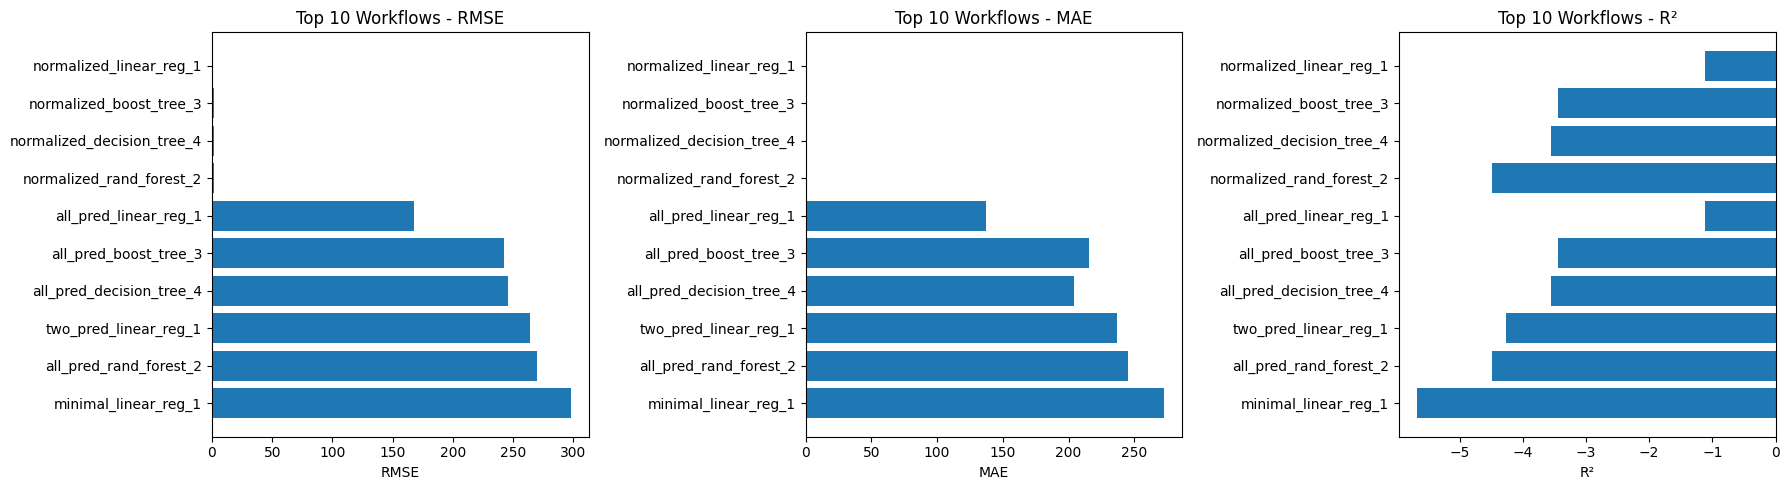

In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
ranked_top10 = ranked.head(10)
axes[0].barh(range(len(ranked_top10)), ranked_top10['rmse'])
axes[0].set_yticks(range(len(ranked_top10)))
axes[0].set_yticklabels(ranked_top10['wflow_id'])
axes[0].set_xlabel('RMSE')
axes[0].set_title('Top 10 Workflows - RMSE')
axes[0].invert_yaxis()

# MAE comparison
axes[1].barh(range(len(ranked_top10)), ranked_top10['mae'])
axes[1].set_yticks(range(len(ranked_top10)))
axes[1].set_yticklabels(ranked_top10['wflow_id'])
axes[1].set_xlabel('MAE')
axes[1].set_title('Top 10 Workflows - MAE')
axes[1].invert_yaxis()

# R² comparison
axes[2].barh(range(len(ranked_top10)), ranked_top10['r_squared'])
axes[2].set_yticks(range(len(ranked_top10)))
axes[2].set_yticklabels(ranked_top10['wflow_id'])
axes[2].set_xlabel('R²')
axes[2].set_title('Top 10 Workflows - R²')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

## 7. Apply Best Workflow to All Groups

Train the best performing workflow on all countries using fit_nested().

In [12]:
# Select best workflow
best_wf_id = ranked.iloc[0]['wflow_id']
best_wf = wf_set.workflows[best_wf_id]

print(f"Best workflow: {best_wf_id}")
print(f"RMSE on Germany: {ranked.iloc[0]['rmse']:.4f}")
print(f"MAE on Germany: {ranked.iloc[0]['mae']:.4f}")
print(f"R² on Germany: {ranked.iloc[0]['r_squared']:.4f}")

Best workflow: normalized_linear_reg_1
RMSE on Germany: 1.0027
MAE on Germany: 0.8233
R² on Germany: -1.1105


In [13]:
# Fit nested on all groups
fit_nested = best_wf.fit_nested(train_data, group_col='country')
fit_nested = fit_nested.evaluate(test_data)

print("\n✓ Best workflow fitted to all groups")


✓ Best workflow fitted to all groups


In [14]:
# Extract outputs
outputs, coefs, stats = fit_nested.extract_outputs()

print("\nTest performance by country:")
test_stats = stats[stats['split'] == 'test']

# Pivot stats from long to wide format for display
test_stats_pivot = test_stats.pivot_table(
    index='group', 
    columns='metric', 
    values='value'
).reset_index()

display(test_stats_pivot[['group', 'rmse', 'mae', 'r_squared']].sort_values('rmse'))


Test performance by country:


metric,group,rmse,mae,r_squared
0,global,194.346523,158.59253,-1.720705


## 8. Visualize Best Model Forecasts

Plot grouped forecasts for all countries.

In [15]:
# Plot forecast for all groups
fig = plot_forecast(
    fit_nested,
    title=f"Best Workflow ({best_wf_id}) - All Groups",
    height=800
)
fig.show()

## 9. Compare Top 3 Workflows Across All Groups

Evaluate multiple top workflows on all groups for comprehensive comparison.

In [16]:
# Get top 3 workflows
top_3_ids = ranked.head(3)['wflow_id'].tolist()

comparison_results = []

for wf_id in top_3_ids:
    print(f"\nEvaluating {wf_id} on all groups...")
    wf = wf_set.workflows[wf_id]
    
    # Fit nested
    fit = wf.fit_nested(train_data, group_col='country')
    fit = fit.evaluate(test_data)
    
    # Extract stats
    outputs, coefs, stats = fit.extract_outputs()
    test_stats = stats[stats['split'] == 'test'].copy()
    test_stats['wflow_id'] = wf_id
    
    comparison_results.append(test_stats)

comparison_df = pd.concat(comparison_results, ignore_index=True)
print("\n✓ Top 3 workflows evaluated on all groups")


Evaluating normalized_linear_reg_1 on all groups...

Evaluating normalized_boost_tree_3 on all groups...

Evaluating normalized_decision_tree_4 on all groups...

✓ Top 3 workflows evaluated on all groups


/Users/matthewdeane/Documents/Data Science/python/_projects/py-tidymodels/py_parsnip/engines/sklearn_decision_tree.py:146: RuntimeWarning:

invalid value encountered in divide



In [17]:
# Summary: Average performance across all groups
# First pivot from long to wide format
comparison_pivot = comparison_df.pivot_table(
    index=['group', 'wflow_id'],
    columns='metric',
    values='value'
).reset_index()

summary = comparison_pivot.groupby('wflow_id').agg({
    'rmse': 'mean',
    'mae': 'mean',
    'r_squared': 'mean'
}).reset_index()

summary = summary.sort_values('rmse')
summary['rank'] = range(1, len(summary) + 1)

print("Average performance across all groups:")
display(summary[['rank', 'wflow_id', 'rmse', 'mae', 'r_squared']])

Average performance across all groups:


metric,rank,wflow_id,rmse,mae,r_squared
0,1,normalized_boost_tree_3,180.05494,146.198604,-1.5774
2,2,normalized_linear_reg_1,194.346523,158.59253,-1.720705
1,3,normalized_decision_tree_4,200.126081,154.481653,-2.076481


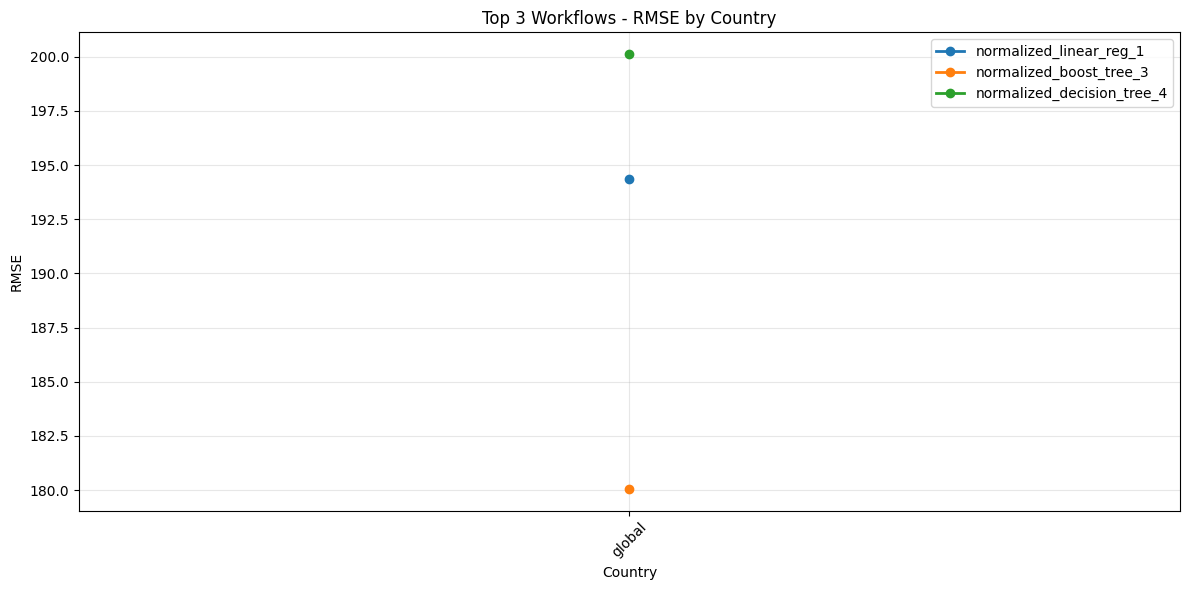

In [18]:
# Visualize performance by group
fig, ax = plt.subplots(figsize=(12, 6))

# Use the pivoted data from previous cell
for wf_id in top_3_ids:
    wf_data = comparison_pivot[comparison_pivot['wflow_id'] == wf_id]
    ax.plot(wf_data['group'], wf_data['rmse'], marker='o', label=wf_id, linewidth=2)

ax.set_xlabel('Country')
ax.set_ylabel('RMSE')
ax.set_title('Top 3 Workflows - RMSE by Country')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary

This notebook demonstrated:

1. **WorkflowSet creation** - Combining 5 preprocessing strategies × 4 models = 20 workflows
2. **Efficient evaluation** - Testing on USA group first to identify top performers
3. **Ranking workflows** - Comparing performance across different combinations
4. **fit_nested() application** - Applying best workflow to all groups independently
5. **Multi-group comparison** - Evaluating top workflows across all countries
6. **Grouped visualization** - Plotting forecasts for all groups

**Key Findings:**
- Best workflow identified based on USA performance
- Performance varies across countries (different data patterns)
- Some workflows generalize better than others across groups

**Next Steps:**
- Try per_group_prep=True for recipe-based workflows to allow group-specific preprocessing
- Add more preprocessing strategies (feature selection, interactions)
- Include hyperparameter tuning within workflow comparison
- Use time series CV for more robust evaluation